In [2]:
import os
import pandas as pd

In [3]:
os.chdir("/Users/mapoa/PycharmProjects/project-voi")

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [5]:
input_folder = '/Users/mapoa/PycharmProjects/project-voi/input'
file_name = 'voiholm.csv'
file_path = os.path.join(input_folder, file_name)

ride_data = pd.read_csv(file_path)

In [6]:
input_folder = '/Users/mapoa/PycharmProjects/project-voi/input'
file_name = 'weather_data.csv'
file_path = os.path.join(input_folder, file_name)

weather_data = pd.read_csv(file_path)

In [7]:
import pandas as pd

def feature_engineering(ride_data, weather_data):
    ride_data['start_time'] = pd.to_datetime(ride_data['start_time'])

    ride_data['date'] = ride_data['start_time'].dt.date
    ride_data['date'] = pd.to_datetime(ride_data['date'])
    ride_data['day_of_week'] = ride_data['start_time'].dt.dayofweek
    ride_data['month'] = ride_data['start_time'].dt.month

    ride_counts_h3index_small = ride_data.groupby(['date', 'h3index_small']).agg(
        num_rides=('ride_id', 'count'),
        start_lon=('start_lon', 'mean'),  
        start_lat=('start_lat', 'mean')   
    ).reset_index()

    ride_counts_h3index_small.sort_values(by=['h3index_small', 'date'], inplace=True)

    ride_counts_h3index_small['lag_1_day_num_rides'] = ride_counts_h3index_small.groupby('h3index_small')['num_rides'].shift(1)
    ride_counts_h3index_small['lag_7_days'] = ride_counts_h3index_small.groupby('h3index_small')['num_rides'].shift(7)
    ride_counts_h3index_small['rolling_avg_7_days'] = ride_counts_h3index_small.groupby('h3index_small')['num_rides'].rolling(window=7).mean().reset_index(0, drop=True)

    ride_counts_h3index_small.fillna(0, inplace=True)

    weather_data['date'] = pd.to_datetime(weather_data['date'])

    additional_features = ride_data[['date', 'day_of_week', 'month']].drop_duplicates()
    processed_data = pd.merge(ride_counts_h3index_small, additional_features, on='date', how='left')

    processed_data = pd.merge(processed_data, weather_data, on='date', how='left')

    return processed_data



In [8]:
processed_data = feature_engineering(ride_data, weather_data)
processed_data

,date,h3index_small,num_rides,start_lon,start_lat,lag_1_day_num_rides,lag_7_days,rolling_avg_7_days,day_of_week,month,temperature,max_temperature,min_temperature,precipitation
0,2020-08-03,891f2506107ffff,1,11.907823,57.690742,0.0,0.0,0.000000,0,8,16.8,19.6,14.3,0.00
1,2020-08-04,891f2506107ffff,2,11.907408,57.690527,1.0,0.0,0.000000,1,8,15.0,17.1,12.8,11.44
2,2020-08-05,891f2506107ffff,2,11.907322,57.690533,2.0,0.0,0.000000,2,8,21.5,26.5,17.0,0.50
3,2020-08-07,891f2506107ffff,2,11.907717,57.690832,2.0,0.0,0.000000,4,8,23.9,29.0,17.3,0.00
4,2020-08-08,891f2506107ffff,2,11.907259,57.690491,2.0,0.0,0.000000,5,8,22.9,28.5,16.1,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,2020-08-30,891f25a9ebbffff,6,11.999882,57.717110,19.0,12.0,9.857143,6,8,14.3,19.0,10.0,0.00
8140,2020-08-17,891f25a9ecbffff,1,11.974992,57.710518,0.0,0.0,0.000000,0,8,23.1,28.7,18.4,0.00
8141,2020-08-21,891f25a9ecbffff,1,11.974746,57.710762,1.0,0.0,0.000000,4,8,20.4,23.0,18.1,3.61
8142,2020-08-23,891f25a9ecbffff,1,11.974710,57.710804,1.0,0.0,0.000000,6,8,16.2,18.6,14.5,0.00


In [9]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

def make_preprocessor(numerical_features, categorical_features):
    numerical_features = [feature for feature in numerical_features if feature not in ['date', 'num_rides']]

    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', make_pipeline(SimpleImputer(strategy="median")), numerical_features),
            ('categorical', make_pipeline(SimpleImputer(strategy="most_frequent")), categorical_features)
        ]
    )
    return preprocessor

def preprocess_data(merged_data_with_weather, preprocessor, numerical_features, categorical_features):
    dates = merged_data_with_weather[['date']]
    num_rides = merged_data_with_weather[['num_rides']]

    features_data = merged_data_with_weather.drop(['date', 'num_rides'], axis=1)

    transformed_data = preprocessor.fit_transform(features_data)

    all_features = numerical_features + categorical_features

    transformed_df = pd.DataFrame(transformed_data, columns=all_features)

    transformed_df['date'] = dates.reset_index(drop=True)
    transformed_df['num_rides'] = num_rides.reset_index(drop=True)

    print("Columns after preprocessing:", transformed_df.columns)

    return transformed_df


In [10]:
processed_data = feature_engineering(ride_data, weather_data)

numerical_features = [
    'start_lon', 'start_lat', 'temperature', 'max_temperature', 
    'min_temperature', 'precipitation', 'lag_1_day_num_rides', 
    'lag_7_days', 'rolling_avg_7_days', 'day_of_week'
]
categorical_features = ['month']

preprocessor = make_preprocessor(numerical_features, categorical_features)

preprocessed_data = preprocess_data(processed_data, preprocessor, numerical_features, categorical_features)


Columns after preprocessing: Index(['start_lon', 'start_lat', 'temperature', 'max_temperature',
       'min_temperature', 'precipitation', 'lag_1_day_num_rides', 'lag_7_days',
       'rolling_avg_7_days', 'day_of_week', 'month', 'date', 'num_rides'],
      dtype='object')


In [11]:
preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['start_lon', 'start_lat', 'temperature',
                                  'max_temperature', 'min_temperature',
                                  'precipitation', 'lag_1_day_num_rides',
                                  'lag_7_days', 'rolling_avg_7_days',
                                  'day_of_week']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['month'])])

In [12]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import os
import joblib

def train_and_evaluate(X_train, y_train, X_test, y_test, output_folder):
    # K-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    mae_scores = []
    rmse_scores = []
    r2_scores = []

    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Train the model
        lgbm_model = lgb.LGBMRegressor()
        lgbm_model.fit(X_train_fold, y_train_fold)

        # Make predictions
        y_pred_fold = lgbm_model.predict(X_test_fold)

        # Evaluate the model
        mae_scores.append(mean_absolute_error(y_test_fold, y_pred_fold))
        rmse_scores.append(mean_squared_error(y_test_fold, y_pred_fold, squared=False))
        r2_scores.append(r2_score(y_test_fold, y_pred_fold))

    # Average scores across all folds
    avg_mae = np.mean(mae_scores)
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)

    print(f"Average MAE: {avg_mae}, Average RMSE: {avg_rmse}, Average R²: {avg_r2}")

    # Training and evaluating without cross-validation
    lgbm_model_final = lgb.LGBMRegressor()
    lgbm_model_final.fit(X_train, y_train)
    y_pred = lgbm_model_final.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print(f"Final Model MAE: {mae}, RMSE: {rmse}, R²: {r2}")
    
    # Save the trained LightGBM model
    lgbm_model_path = os.path.join(output_folder, 'trained_model.txt')
    lgbm_model_final.booster_.save_model(lgbm_model_path)
    print(f"Final LightGBM Model saved at: {lgbm_model_path}")

    # Save the trained scikit-learn model
    sklearn_model_path = os.path.join(output_folder, 'model.pkl')
    joblib.dump(lgbm_model_final, sklearn_model_path)
    print(f"Final Scikit-learn Model saved at: {sklearn_model_path}")

In [13]:
preprocessed_data['date'] = pd.to_datetime(preprocessed_data['date'])

max_date = preprocessed_data['date'].max()
cutoff_date = max_date - pd.DateOffset(weeks=1)
train_data = preprocessed_data[preprocessed_data['date'] <= cutoff_date]
test_data = preprocessed_data[preprocessed_data['date'] > cutoff_date]

features = ['start_lon', 'start_lat', 'temperature', 'max_temperature', 'min_temperature', 'precipitation',
            'lag_1_day_num_rides', 'lag_7_days', 'rolling_avg_7_days', 'day_of_week', 'month']
target = 'num_rides'

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]
output_folder = '/Users/mapoa/PycharmProjects/project-voi/output'
train_and_evaluate(X_train, y_train, X_test, y_test, output_folder)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1106
[LightGBM] [Info] Number of data points in the train set: 4973, number of used features: 10
[LightGBM] [Info] Start training from score 20.269656
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 4973, number of used features: 10
[LightGBM] [Info] Start training from score 19.912729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 4974, number of used features: 10
[LightGBM] [Info] Start trai

In [14]:
common_indexes = train_data.index.intersection(test_data.index)
print("Number of common indexes:", len(common_indexes))

Number of common indexes: 0


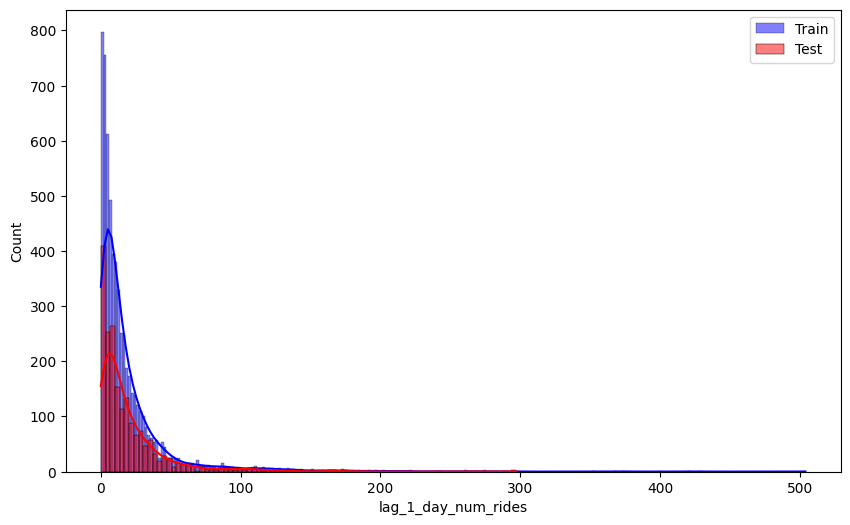

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(train_data['lag_1_day_num_rides'], color='blue', alpha=0.5, label='Train', kde=True)
sns.histplot(test_data['lag_1_day_num_rides'], color='red', alpha=0.5, label='Test', kde=True)

plt.xlabel('lag_1_day_num_rides')
plt.ylabel('Count')
plt.legend()

plt.show()


In [16]:
combined_data = pd.concat([train_data, test_data])
duplicates = combined_data.duplicated(keep=False)
print("Number of duplicates across train and test sets:", duplicates.sum())

Number of duplicates across train and test sets: 0


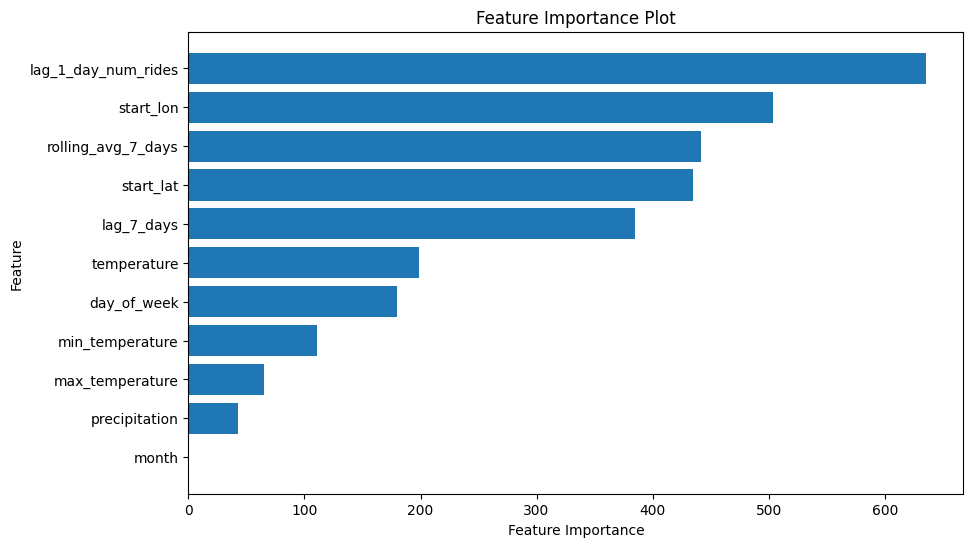

In [17]:
import joblib
import matplotlib.pyplot as plt

model_path = '/Users/mapoa/PycharmProjects/project-voi/output/model.pkl'
loaded_model = joblib.load(model_path)

feature_importance_loaded = loaded_model.feature_importances_

features = ['start_lon', 'start_lat', 'temperature', 'max_temperature', 'min_temperature', 'precipitation',
            'lag_1_day_num_rides', 'lag_7_days', 'rolling_avg_7_days', 'day_of_week', 'month']

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance_loaded})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important feature at the top
plt.show()


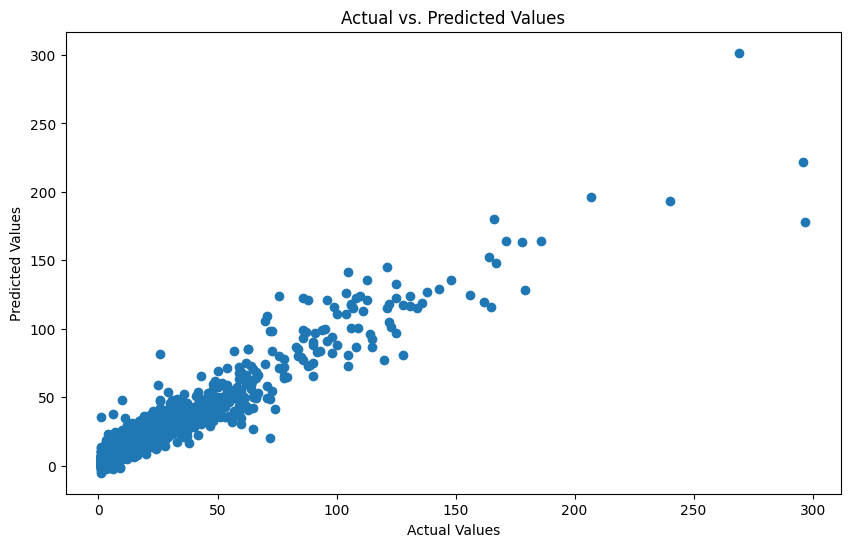

In [18]:
loaded_model = joblib.load('/Users/mapoa/PycharmProjects/project-voi/output/model.pkl')

y_pred = loaded_model.predict(X_test)

# Create the actual vs. predicted values plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()


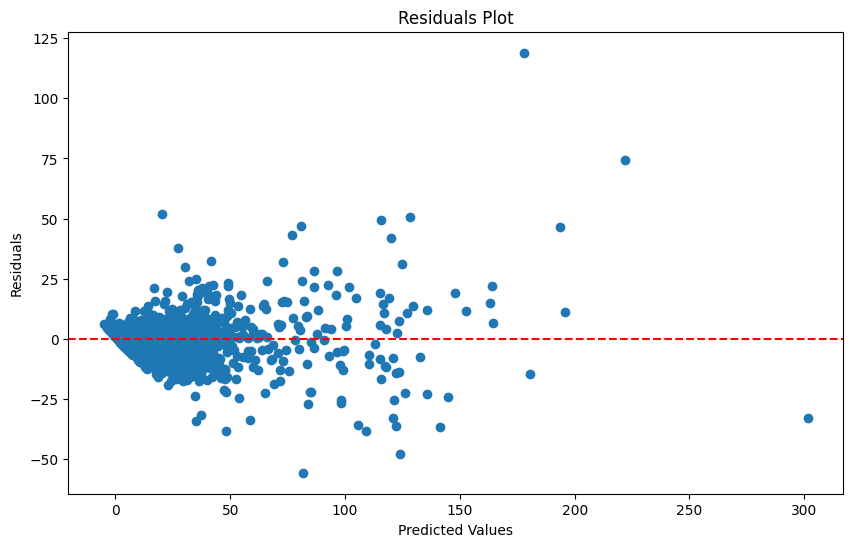

In [19]:
import joblib
import matplotlib.pyplot as plt

loaded_model = joblib.load('/Users/mapoa/PycharmProjects/project-voi/output/model.pkl')

y_pred = loaded_model.predict(X_test)

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()



/var/folders/2x/gmk7lkk108vfb2vkxl1s8kt4bnyk8y/T/ipykernel_7024/608679616.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['date'] = pd.to_datetime(test_data['date'])


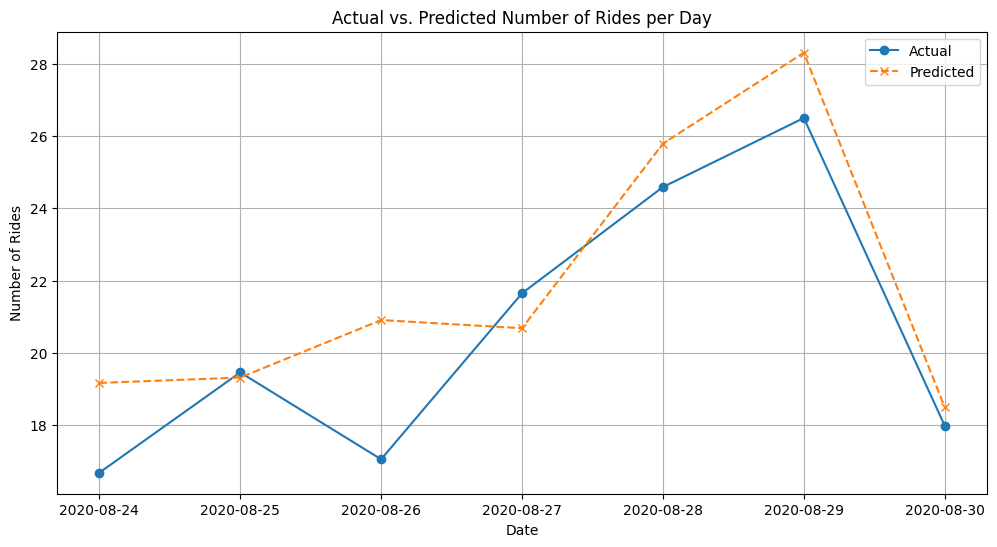

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

test_data['date'] = pd.to_datetime(test_data['date'])

predictions = loaded_model.predict(test_data[features])

results_df = pd.DataFrame({
    'date': test_data['date'],
    'actual_num_rides': test_data[target],  
    'predicted_num_rides': predictions
})

aggregated_data = results_df.groupby('date').mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(aggregated_data['date'], aggregated_data['actual_num_rides'], label='Actual', linestyle='-', marker='o')
plt.plot(aggregated_data['date'], aggregated_data['predicted_num_rides'], label='Predicted', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.title('Actual vs. Predicted Number of Rides per Day')
plt.legend()
plt.grid(True)
plt.show()
